<a href="https://colab.research.google.com/github/YoshifumiMiyagi/IP_LDL/blob/main/IP_LDL_SHAP(DF2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import early_stopping

raw = pd.read_excel('/content/drive/MyDrive/R7_2_10_DB2_miyagi.xlsx')
print(raw.shape)
raw.head()

(71, 35)


,カルテ番号,Birth_date,Examin_date,"Age_lessthan10_0,morethan11_1",Age_y,Age_m,Age_day,sex,Hight,Weight,...,BPStart_mmHg_2,BPEnd_mmHg_2,BPInterval_mmHg_2,BPStart_mmHg_3,BPEnd_mmHg_3,BPInterval_mmHg_3,Time_2,Time_3,Time_12,Time_13
0,10637737,36069,43319,1,19,10,5.0,female,150.0,NaN,...,101.000000,103.666667,2.666667,78.000000,79.000000,1.000000,0.038339,0.067093,0.036036,0.063063
1,12046291,37930,43692,1,15,9,9.0,female,158.2,47.0,...,98.188679,107.018868,8.830189,70.716981,77.584906,6.867925,0.063380,0.084507,0.037037,0.049383
2,12812817,38630,45133,1,17,9,19.0,female,163.0,45.8,...,96.873239,102.704225,5.830986,65.126761,77.436620,12.309859,0.044280,0.044280,0.048193,0.048193
3,10843052,36984,42586,1,15,4,1.0,male,174.1,56.5,...,110.228571,116.028571,5.800000,71.285714,72.942857,1.657143,0.067606,0.059155,0.054422,0.047619
4,10982985,40485,44412,0,10,9,0.0,female,141.0,35.0,...,110.272727,117.363636,7.090909,71.272727,78.363636,7.090909,0.047022,0.075235,0.054945,0.087912


In [31]:
data = raw.iloc[:,3:]
data['sex'] = data['sex'].map({'male':1,'female':0})
#data['Age_day'] = data['Age_day'].fillna(0)
data['LDL'] = data['LDL']
data = data.dropna(subset=['LDL'])

In [32]:
import re
data = data.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
data.columns

Index(['Age_lessthan10_0_morethan11_1', 'Age_y', 'Age_m', 'Age_day', 'sex',
       'Hight', 'Weight', 'HR', 'sysBP', 'dysBP', 'aveBP', 'LDL', 'LDL_140',
       'LDL_z', 'LDL_z_2_5', 'Coeff_3', 'Coeff_2', 'Coeff_1', 'Coeff_0',
       'BPStart_mmHg_1', 'BPEnd_mmHg_1', 'BPInterval_mmHg_1', 'BPStart_mmHg_2',
       'BPEnd_mmHg_2', 'BPInterval_mmHg_2', 'BPStart_mmHg_3', 'BPEnd_mmHg_3',
       'BPInterval_mmHg_3', 'Time_2', 'Time_3', 'Time_12', 'Time_13'],
      dtype='object')

In [42]:
data['LDL_z_2_5'].value_counts()

,count
LDL_z_2_5,
1,43
0,28


In [45]:
# prompt: lightGBMで分類　性能を

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import early_stopping
import re

# Assuming the code you provided is already executed and 'data' DataFrame is available

# Define features (X) and target variable (y)
X = data.drop(['LDL', 'LDL_140', 'LDL_z', 'LDL_z_2_5'], axis=1)  # Replace 'CAD' with your target column name
y = data['LDL_z_2_5']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify = y) # Adjust test_size as needed

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters for LightGBM
params = {'max_depth': 3,
    'objective': 'binary',  # For binary classification
    'metric': 'binary_logloss', # or 'auc'
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train the model with early stopping
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000, # Adjust as needed
    valid_sets=test_data,
    callbacks=[early_stopping(stopping_rounds=50)] # Stop if no improvement for 50 rounds
)


# Make predictions on the test set
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")
print(classification_report(y_test, y_pred_binary))
print(confusion_matrix(y_test,y_pred_binary))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[201]	valid_0's binary_logloss: 0.115131
Accuracy: 1.0
AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         9

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

[[6 0]
 [0 9]]


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


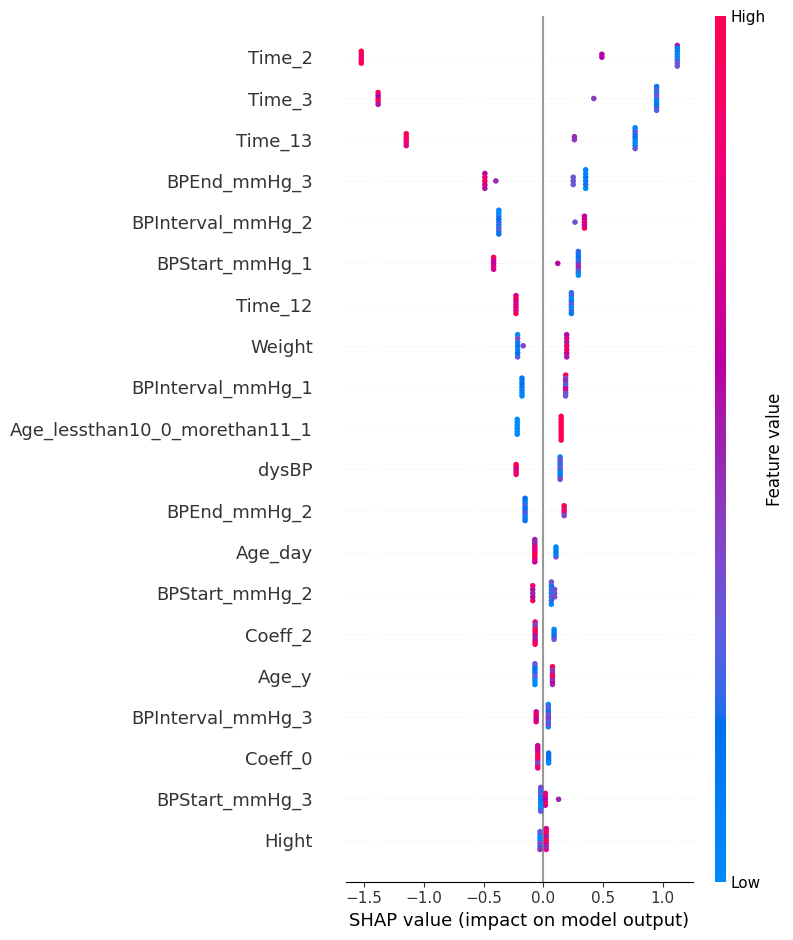

In [46]:
# prompt: SHAPで特徴量選択を

import pandas as pd
import numpy as np
import shap

# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test)


In [47]:
# Get feature importance based on SHAP values
shap_importances = pd.DataFrame(
    {"feature": X_test.columns, "importance": np.abs(shap_values).mean(0)}
)
shap_importances = shap_importances.sort_values(by="importance", ascending=False)

print(shap_importances)

# You can use the shap_importances DataFrame to select the most important features
# For example, to keep the top 10 features:
top_10_features = shap_importances["feature"].head(7).tolist()
X_train_selected = X_train[top_10_features]
X_test_selected = X_test[top_10_features]


# Retrain your model with the selected features
# ... (code to retrain the model with X_train_selected and X_test_selected)

                          feature  importance
24                         Time_2    1.173100
25                         Time_3    1.059616
27                        Time_13    0.828407
22                   BPEnd_mmHg_3    0.382132
20              BPInterval_mmHg_2    0.356290
15                 BPStart_mmHg_1    0.323375
26                        Time_12    0.232480
6                          Weight    0.203139
17              BPInterval_mmHg_1    0.183250
0   Age_lessthan10_0_morethan11_1    0.177494
9                           dysBP    0.170276
19                   BPEnd_mmHg_2    0.159700
3                         Age_day    0.082445
18                 BPStart_mmHg_2    0.080401
12                        Coeff_2    0.075373
1                           Age_y    0.073220
23              BPInterval_mmHg_3    0.048171
14                        Coeff_0    0.045552
21                 BPStart_mmHg_3    0.027051
5                           Hight    0.025832
8                           sysBP 